# The redshift evolution of the BBH merger rate: "a weighty matter"

## Figure 6: the contribution of different metallicities to the BH primary mass distribution 


## Imports and definitions:

In [2]:
######################################
## Imports
import numpy as np
import h5py as h5

from astropy.table import vstack, Table, Column
import astropy.units as u
from astropy import constants as const

import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u

from matplotlib import ticker, cm

from scipy import stats

# Chosen cosmology 
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

# Extra python functions
import HelperFunctions as func

######################################
## locations
save_loc    =  '../plots/'
data_dir    = '../output/'

# This will be put in front of the name for every figure we safe 
sim_save_str = 'N1e7_'

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Read your data

the function `read_data` is part of `HelperFunctions.py` and reads the hdf5 file containing the BBH population data and merger rates. This is expensive memory-wise
Hence the columns specifically needed for this  Figure are loaded right below that

The Bool "DCO_mask" filters for BBHs:  
1. with an inspiral time that is less than the age of the Universe
2. excludes systems that experienced a CE from a HG donor (i.e. the flag `Optimistic_CE == False`)
3. excludes systems that experienced RLOF immediately following a CE (i.e. the flag `Immediate_RLOF>CE == False`)

In other words, we treat 2. and 3. as stellar mergers and exclude them from the rest of our analysis

Lastly, we select merging BBHs using the `DCO_mask`, and aditionally exclude systems that evolve Chemically homogeneous. 


In [3]:
####################################################
## Location of your data
File_location = data_dir+'COMPAS_Output_wWeights.h5'
print(File_location)

# Rate selects wich mergers you are interested in, using a specific SFRD
rate_key      = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'

####################################################
'''
The following function will read more information (generally useful for all plots in paper)
Warning, this is heavy on memory usage 
Bare essential data will be read below
DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0, = func.read_data(loc = File_location, rate_key = rate_key)
DCO.info()
'''

################################################
## Essential data for this plot
## Open hdf5 file and read relevant columns
File        = h5.File(File_location ,'r')

DCO = Table()
DCO['SEED']                  = File['DoubleCompactObjects']['SEED'][()] 
DCO['Metallicity@ZAMS(1)']   = File['DoubleCompactObjects']['Metallicity@ZAMS(1)'][()] 
DCO['CE_Event_Count']        = File['DoubleCompactObjects']['CE_Event_Count'][()] 
DCO['M_moreMassive']         = np.maximum(File['DoubleCompactObjects']['Mass(1)'][()], File['DoubleCompactObjects']['Mass(2)'][()])

SYS_DCO_seeds_bool           = np.in1d(File['SystemParameters']['SEED'][()], DCO['SEED']) #Bool to point SYS to DCO
DCO['Stellar_Type@ZAMS(1)']  = File['SystemParameters']['Stellar_Type@ZAMS(1)'][SYS_DCO_seeds_bool]

DCO_mask                     = File[rate_key]['DCOmask'][()] # Mask from DCO to merging BBH 
intrinsic_rate_density       = File[rate_key]['merger_rate'][()]
redshifts                    = File[rate_key]['redshifts'][()]

File.close()

################################################
# Bools to select merging BBHs w.o. CHE only
nonCHE_bool         = DCO['Stellar_Type@ZAMS(1)'] != 16
rate_nonCHE_bool    = DCO['Stellar_Type@ZAMS(1)'][DCO_mask] != 16

# Filter both the BBH table and the intrinsic rate data
merging_BBH         = DCO[DCO_mask * nonCHE_bool]
Red_intr_rate_dens  = intrinsic_rate_density[rate_nonCHE_bool, :]


../output/COMPAS_Output_wWeights.h5


# Look at contribution from different metallicities to the BH mass distribution

In [4]:
# Distribution plot function
def plot_dist_by_redshift_Z(tables, x_key, crude_rate_densities, log = False, kde_width = 0.1, 
                            fill=True, labels = ['',''],title_label = '',
                            metal_edges = [-3.5,-3,-2.5,-2,-1.5], annotate_stuff=True,print_MBHmax = True,
                            bins = np.arange(0,50,2), leg_args = {'bbox_to_anchor':(1.005, 0.85), 'loc':'upper left'}, 
                            savestr = '', save_plot=False, x_lim=(0,52.5), y_lim = (0,1000), linewidths = [5,5,5,5,5],
                            colors = ['#488496', '#73bdb3', '#e388b0'], linestyles = ['-', '--', '-.',':', '-'],
                            xlabel = '$M_{\mathrm{BH,1} \ } [\mathrm{M_{\odot}} ]$',
                            ylabel = r'$R_{\mathrm{BBH} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}}]}$',):

    #########################################
    # Metal Labels
    metal_labels     = ['$(%s , %s]$'%(np.round(metal_edges[a],2),np.round(metal_edges[a+1],2) ) for a in range(0,len(metal_edges)-1) ]
    # add one bool for to include the total 
    metal_labels.insert(0,'$\mathrm{All} \ Z$') #len(metal_bool_list)
    

    max_MBH_masses = []
    
    #########################################
    # Start plotting
    fig, ax = plt.subplots(figsize = (12, 8))

    zorders = [1,2,3,4,0] 
    
    color_i = 0
    #########################################
    # Loop over all tables (i.e. if split by channel)
    for t, table in enumerate(tables):  
        ##############################
        ## Average rate density per z-bin
        crude_rate_density = crude_rate_densities[t]
        
        #########################################
        # METAL bools
        table['logZ'] = np.log10(table['Metallicity@ZAMS(1)'])
        metal_bool_list = [np.logical_and(table['logZ'] > metal_edges[a], table['logZ']<= metal_edges[a+1]) for a in range(0,len(metal_edges)-1) ]
        # add one bool for to include the total 
        metal_bool_list.insert(0,table['logZ'] < metal_edges[-1])
        
        #########################################
        # Loop over all metallicities
        for met, metal_bool in enumerate(metal_bool_list):
            print('t', t, 'met', met, metal_labels[met], 'color_i',color_i)
            ########################
            # X value and weight
            x_vals        = table[x_key][metal_bool]
            m_Weight      = crude_rate_density[metal_bool]
            
            ########################
            # Get the Hist    
            hist, bin_edge = np.histogram(x_vals, weights = m_Weight, bins=bins)
            center_bins = (bin_edge[:-1] + bin_edge[1:])/2.
            # And the KDE
            kernel = stats.gaussian_kde(x_vals, bw_method= kde_width, weights=m_Weight)
            binwidth = np.diff(bin_edge)


            ########################
            # Add KDE
            x_KDE = np.arange(2.5,bins[-1],0.1)
            KDEy_vals = kernel(x_KDE)*sum(hist)*np.diff(bins)[0] #re-normalize the KDE

            # Find the max BH mass and metal bin
            Mbh_max = max(x_KDE[KDEy_vals > 1e-3])

            # Stuff for the legend handles
            if print_MBHmax:
                max_MBH_masses.append(Mbh_max)
                labelstr = metal_labels[met] 
            else: 
                labelstr = None
                if t == 0: # Only add lables to the first table
                    ax.plot((60,65), (-1, -1), lw=linewidths[met], color='darkgrey', ls = linestyles[met], zorder = 50,label = metal_labels[met] )
                
            # Plot the actual thing
            ax.plot(x_KDE, KDEy_vals, lw=linewidths[met], color=colors[color_i], ls = linestyles[met], zorder = 50,label = labelstr)
            
            if fill:
                if np.logical_and(print_MBHmax == False, met == 0):
                    ax.fill_between(x_KDE, y1=0, y2=KDEy_vals, color=colors[1 + t*5], alpha = 0.05, zorder = t+1) # Fill with the low Z color
                elif np.logical_and(print_MBHmax == True, met != 0):
                    ax.fill_between(x_KDE, y1=0, y2=KDEy_vals, color=colors[1 + t*5], alpha = 0.05, zorder = t+1) # Fill with the low Z color
                else:
                    print('dont fill the seperate dists')
            color_i += 1


    print(max_MBH_masses)
    # Annotating max BH masses by hand
    if print_MBHmax: 
        #lowest Z == all
        ax.annotate('$ %s \mathrm{M_{\odot}}$'%(int(np.round(max_MBH_masses[1]))), (max_MBH_masses[1]-1,2e-1), xytext = (max_MBH_masses[1] ,5e-1) , color = colors[1], ha = 'left',
                    arrowprops=dict(arrowstyle= '-|>', color=colors[1],lw=3.5), zorder = 100)
        # one but lowest metals
        ax.annotate('$ %s \mathrm{M_{\odot}}$'%(int(np.round(max_MBH_masses[2]))), (max_MBH_masses[2]-1,2e-2), xytext = (max_MBH_masses[2]-6,1e-1) , color = colors[2], ha = 'left',
                    arrowprops=dict(arrowstyle= '-|>', color=colors[2],lw=3.5), zorder = 100) 
        # one but highest metals
        ax.annotate('$ %s \mathrm{M_{\odot}}$'%(int(np.round(max_MBH_masses[3]))), (max_MBH_masses[3]-1,2e-2), xytext = (max_MBH_masses[3]-5,5e-2) , color = colors[3], ha = 'left',
                    arrowprops=dict(arrowstyle= '-|>', color=colors[3],lw=3.5), zorder = 100) 
        # highest metals
        ax.annotate('$ %s \mathrm{M_{\odot}}$'%(int(np.round(max_MBH_masses[4]))), (max_MBH_masses[4]-1,2e-2), xytext = (max_MBH_masses[4]-5,5e-2) , color = colors[4], ha = 'left',
                    arrowprops=dict(arrowstyle= '-|>', color=colors[4],lw=3.5), zorder = 100) 
    else:
        ax.annotate('$\mathrm{CE \ Channel}$', (10,4), xytext = (1,10) , color ='dimgrey', ha = 'left',
                    arrowprops=dict(arrowstyle= '-|>', color='dimgrey',lw=3.5), zorder = 100) 
        ax.annotate('$\mathrm{Stable \ RLOF \ Channel}$', (26.5,3), xytext =(18, 15)  , color ='dimgrey', ha = 'left',
                    arrowprops=dict(arrowstyle= '-|>', color='dimgrey',lw=3.5), zorder = 100) 
    
    #########################################
    # plot values
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    leg = ax.legend(title= '$\log_{10} \mathrm{Metallicity}$ ',fontsize = 22,**leg_args) #+mbhmax_leg_string
    leg.set_zorder(100)
    leg._legend_box.align='right'
    
    ax.text(0.1, 0.925, title_label, ha = 'left', transform=ax.transAxes)
    
    ax.set_xlabel(xlabel, fontsize = 35)
    ax.set_ylabel(ylabel, fontsize = 30)
    ax.tick_params(axis='both', labelsize= 35)
    if log:
        ax.set_yscale('log')
        
    if save_plot:
        plt.savefig(save_loc+'/Mass_dist_by_metallicity'+savestr+'.pdf', bbox_inches='tight')
        plt.savefig(save_loc+'/png_versions/Mass_dist_by_metallicity'+savestr+'.png', bbox_inches='tight')

    plt.show()


    

# Split by 4 metallicity bins

i_per_crude_bin 10.0
t 0 met 0 $\mathrm{All} \ Z$ color_i 0
dont fill the seperate dists
t 0 met 1 $(-4 , -3]$ color_i 1
t 0 met 2 $(-3 , -2.5]$ color_i 2
t 0 met 3 $(-2.5 , -2]$ color_i 3
t 0 met 4 $(-2 , -1.5]$ color_i 4
[47.80000000000004, 47.90000000000004, 43.80000000000004, 32.00000000000003, 18.000000000000014]


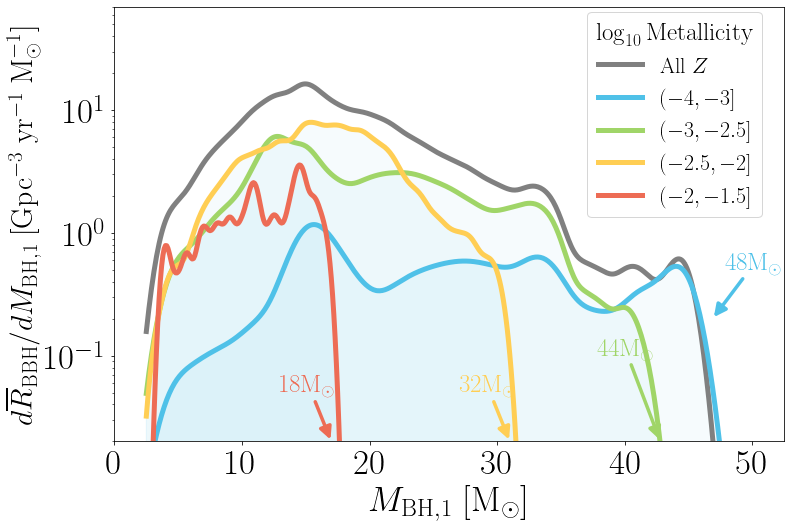

In [82]:
z_bin_edges = np.array([0,0.5])

#########################################
# centers of redshif bins
center_z = (redshifts[:-1] + redshifts[1:])/2.
#Centers of your crude redshift bins
center_Crude_bins = (z_bin_edges[:-1] + z_bin_edges[1:])/2. # center points

#########################################
## Calculate average rate density per z-bin
crude_rate_density = func.get_crude_rate_density(Red_intr_rate_dens, redshifts, z_bin_edges)

#########################################
# labels based on z_bin_edges
labels     = ['$%s \leq \mathrm{merger \ redshift,} z < %s$'%(z_bin_edges[a],z_bin_edges[a+1]) for a in range(0,len(z_bin_edges)-1) ]


#########################################
kleuren_lijst = ['grey', '#4FC1E8', '#A0D568', '#FFCE54', '#ed6c55', '#6e6e6e']

#########################################
# !! Only works for one redshift bin
plot_dist_by_redshift_Z([merging_BBH], 'M_moreMassive', [crude_rate_density[:,0]], 
                        metal_edges = [-4,-3,-2.5,-2,-1.5],fill=True, title_label = '',#'$\mathrm{Split \ by \ metallicity}$',
                        colors = kleuren_lijst, y_lim = (2e-2,7e1), linestyles = ['-', '-', '-','-', '-'],
                        ylabel = r'$d\overline{R}_{\mathrm{BBH}}/dM_{\mathrm{BH,1}} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}]}$',
                        log = True, savestr = sim_save_str+'0z_leq2', save_plot=True, leg_args = {'bbox_to_anchor':(0.69, 0.49), 'loc':'lower left', 'ncol':1}) #(0.17, 0.015)




# Split by channel and by metallicity

i_per_crude_bin 10.0
t 0 met 0 $\mathrm{All} \ Z$ color_i 0
t 0 met 1 $(-4 , -3]$ color_i 1
dont fill the seperate dists
t 0 met 2 $(-3 , -2.5]$ color_i 2
dont fill the seperate dists
t 0 met 3 $(-2.5 , -2]$ color_i 3
dont fill the seperate dists
t 1 met 0 $\mathrm{All} \ Z$ color_i 4
t 1 met 1 $(-4 , -3]$ color_i 5
dont fill the seperate dists
t 1 met 2 $(-3 , -2.5]$ color_i 6
dont fill the seperate dists
t 1 met 3 $(-2.5 , -2]$ color_i 7
dont fill the seperate dists
[]


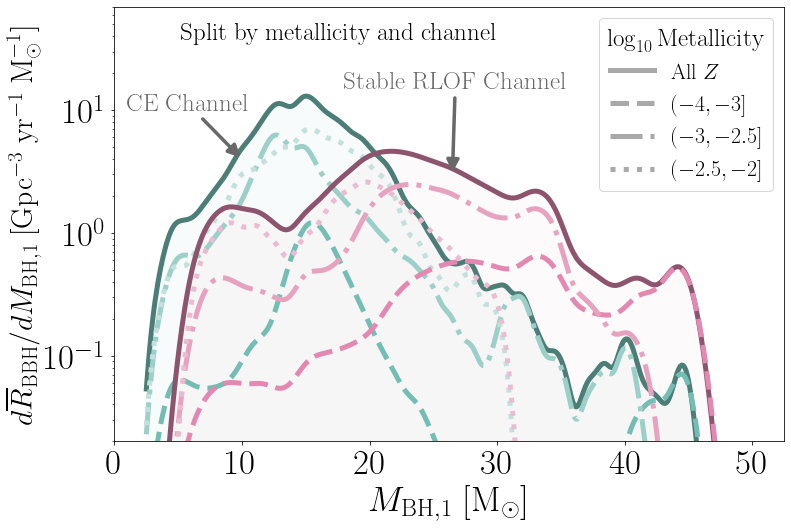

In [13]:
z_bin_edges = np.array([0,0.5])

##########################################
## Calculate average rate density per z-bin
crude_rate_density    = func.get_crude_rate_density(Red_intr_rate_dens[:,:], redshifts, z_bin_edges)
weights               = crude_rate_density[:,0]

# CE channel
BBH_CEchannel         = merging_BBH[merging_BBH['CE_Event_Count'] >0]
CEchannel_weights     = weights[merging_BBH['CE_Event_Count'] >0]

# stable RLOF channel
BBH_stablechannel     = merging_BBH[merging_BBH['CE_Event_Count'] == 0]
stablechannel_weights = weights[merging_BBH['CE_Event_Count'] == 0]


#########################################
# CE channel
CE_col                = np.vstack([sns.light_palette("#4c7d76",reverse=True, n_colors=1) ,sns.light_palette("#73bdb3",reverse=True, n_colors=4)[0:-1]])
# Stable channel
stable_col            = np.vstack([sns.light_palette("#8c546d",reverse=True, n_colors=1) ,sns.light_palette("#e388b0",reverse=True, n_colors=5)[0:-2]])
kleuren_lijst         = np.vstack([CE_col,stable_col])

#########################################
# !! Only works for one redshift bin
plot_dist_by_redshift_Z([BBH_CEchannel,BBH_stablechannel], 'M_moreMassive', [CEchannel_weights, stablechannel_weights],
                        metal_edges = [-4,-3,-2.5,-2] , fill=True,print_MBHmax = False, 
                        colors = kleuren_lijst, y_lim = (2e-2,7e1), title_label = '$\mathrm{Split \ by \ metallicity \ and \ channel}$', linewidths = [5,5,5,5,3],
                        ylabel = r'$d\overline{R}_{\mathrm{BBH}}/dM_{\mathrm{BH,1}} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}]}$',
                        log = True, savestr = sim_save_str+'channels_0z_leq2', save_plot=False,
                       leg_args = {'loc':'upper right'})

kleuren_lijst         = np.vstack([stable_col])




t 0 met 0 $\mathrm{All} \ Z$ color_i 0
t 0 met 1 $(-4 , -3]$ color_i 1
dont fill the seperate dists
t 0 met 2 $(-3 , -2.5]$ color_i 2
dont fill the seperate dists
t 0 met 3 $(-2.5 , -2]$ color_i 3
dont fill the seperate dists
t 0 met 4 $(-2 , -1.5]$ color_i 4
dont fill the seperate dists
[]


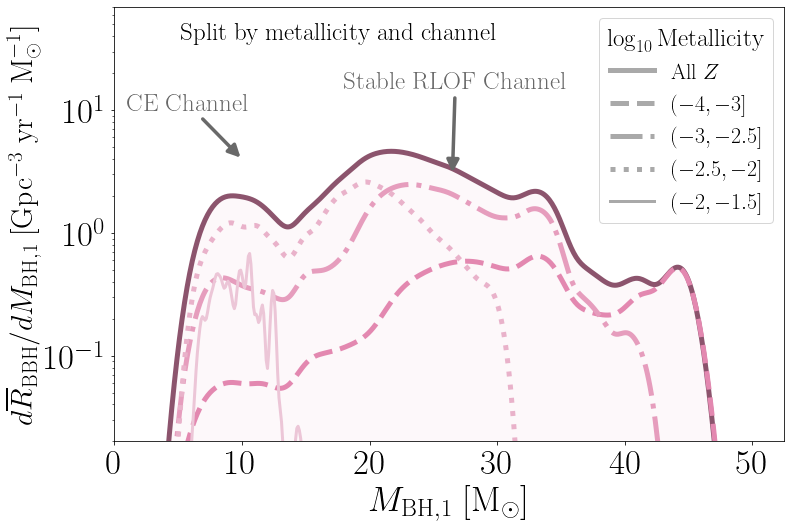

t 0 met 0 $\mathrm{All} \ Z$ color_i 0
t 0 met 1 $(-4 , -3]$ color_i 1
dont fill the seperate dists
t 0 met 2 $(-3 , -2.5]$ color_i 2
dont fill the seperate dists
t 0 met 3 $(-2.5 , -2]$ color_i 3
dont fill the seperate dists
t 0 met 4 $(-2 , -1.5]$ color_i 4
dont fill the seperate dists
[]


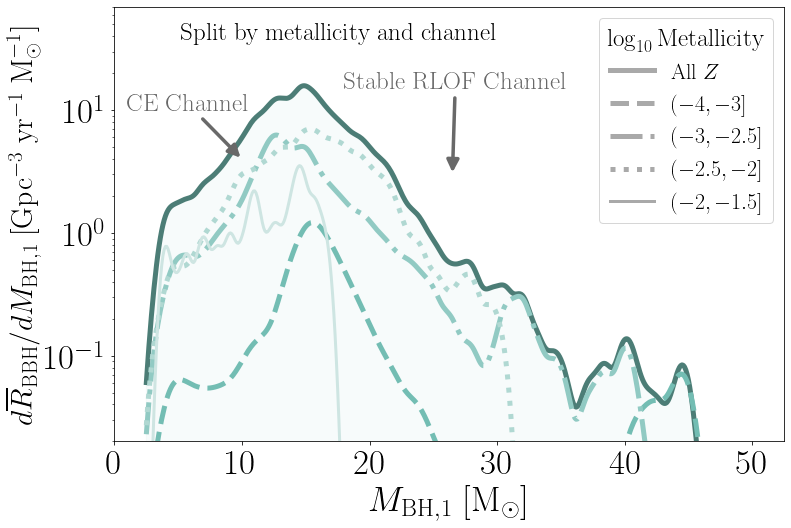

In [12]:
stable_col            = np.vstack([sns.light_palette("#8c546d",reverse=True, n_colors=1) ,sns.light_palette("#e388b0",reverse=True, n_colors=6)[0:-2]])
kleuren_lijst         = np.vstack([stable_col])

# !! Only works for one redshift bin
plot_dist_by_redshift_Z([BBH_stablechannel], 'M_moreMassive', [stablechannel_weights],
                        metal_edges = [-4,-3,-2.5,-2,-1.5] , fill=True,print_MBHmax = False, 
                        colors = kleuren_lijst, y_lim = (2e-2,7e1), title_label = '$\mathrm{Split \ by \ metallicity \ and \ channel}$', linewidths = [5,5,5,5,3],
                        ylabel = r'$d\overline{R}_{\mathrm{BBH}}/dM_{\mathrm{BH,1}} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}]}$',
                        log = True, savestr = sim_save_str+'channels_0z_leq2', save_plot=False,
                       leg_args = {'loc':'upper right'})


CE_col                = np.vstack([sns.light_palette("#4c7d76",reverse=True, n_colors=1) ,sns.light_palette("#73bdb3",reverse=True, n_colors=5)[0:-1]])
kleuren_lijst         = np.vstack([CE_col])

#########################################
# !! Only works for one redshift bin
plot_dist_by_redshift_Z([BBH_CEchannel], 'M_moreMassive', [CEchannel_weights],
                        metal_edges = [-4,-3,-2.5,-2,-1.5] , fill=True,print_MBHmax = False, 
                        colors = kleuren_lijst, y_lim = (2e-2,7e1), title_label = '$\mathrm{Split \ by \ metallicity \ and \ channel}$', linewidths = [5,5,5,5,3],
                        ylabel = r'$d\overline{R}_{\mathrm{BBH}}/dM_{\mathrm{BH,1}} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}]}$',
                        log = True, savestr = sim_save_str+'channels_0z_leq2', save_plot=False,
                       leg_args = {'loc':'upper right'})

